In [74]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Comparison to QuTip

In [75]:
import matplotlib.pyplot as plt
import numpy as np

### Local X-chain

In [76]:
factor = 0.5
num_sites = 10

#### QuTip

In [77]:
from qutip import (basis,
                   sesolve,
                   qeye,
                   sigmaz,
                   sigmax,
                   tensor)

In [78]:
local_state = basis(2, 0)
initial_state = tensor([local_state] * num_sites)
H = 0
for i in range(num_sites):
    op_list = [qeye(2)] * num_sites
    op_list[i] = sigmax()
    H += factor * tensor(op_list)
z_list = []
for i in range(num_sites):
    op_list = [qeye(2)] * num_sites
    op_list[i] = sigmaz()
    z_list.append(tensor(op_list))
tlist = np.linspace(0, 10, 100)

In [79]:
results = sesolve(H, initial_state, tlist, e_ops=z_list)

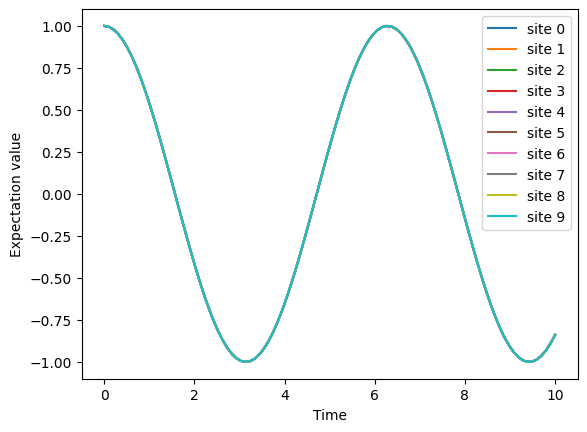

In [80]:
for i in range(num_sites):
    plt.plot(tlist, results.expect[i], label=f"site {i}")
plt.xlabel("Time")
plt.ylabel("Expectation value")
plt.legend()
plt.show()

#### PyTreeNet

In [81]:
from pytreenet.time_evolution.bug import BUG, BUGConfig
from pytreenet.time_evolution.time_evolution import TimeEvoMode
from pytreenet.special_ttn.special_states import (generate_zero_state,
                                                  TTNStructure,
                                                  STANDARD_NODE_PREFIX)
from pytreenet.operators.sim_operators import single_site_operators
from pytreenet.operators.hamiltonian import Hamiltonian
from pytreenet.operators.common_operators import pauli_matrices
from pytreenet.operators.models.eval_ops import local_magnetisation
from pytreenet.ttno import TTNO

In [82]:
init_state = generate_zero_state(num_sites, TTNStructure.BINARY, phys_dim=2, bond_dim=2)
node_ids = [STANDARD_NODE_PREFIX + str(i) for i in range(num_sites)]
single_site_ops = single_site_operators("X", node_ids, factor=(1,"J"))
single_site_ops = list(single_site_ops.values())
ham = Hamiltonian()
ham.add_multiple_terms(single_site_ops)
ham.conversion_dictionary["X"] = pauli_matrices()[0]
ham.coeffs_mapping["J"] = 0.5
ham.include_identities([1,2])
ham_ttno = TTNO.from_hamiltonian(ham, init_state)
config = BUGConfig(time_evo_mode=TimeEvoMode.RK45)
eval_ops = local_magnetisation(node_ids)
bug = BUG(init_state, ham_ttno, 0.1, 10, eval_ops, config=config,
          solver_options={"rtol": 1e-8, "atol": 1e-8})
bug.run()
results = bug.results

100%|██████████| 101/101 [00:05<00:00, 19.21it/s]


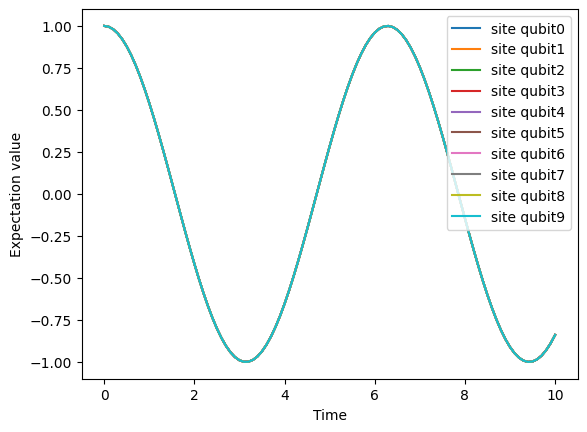

In [83]:
times = results.times()
for node_id in node_ids:
    resu = results.operator_result(node_id,realise=True)
    plt.plot(times, resu, label=f"site {node_id}")
plt.xlabel("Time")
plt.ylabel("Expectation value")
plt.legend()
plt.show()

### Ising Chain

In [84]:
ext_magn = 0.3

#### QuTip

In [85]:
local_state = basis(2, 0)
initial_state = tensor([local_state] * num_sites)
H = 0
for i in range(num_sites):
    op_list = [qeye(2)] * num_sites
    op_list[i] = sigmaz()
    H += ext_magn * tensor(op_list)
    if i < num_sites - 1:
        op_list = [qeye(2)] * num_sites
        op_list[i] = sigmax()
        op_list[i + 1] = sigmax()
        H += factor * tensor(op_list)
z_list = []
for i in range(num_sites):
    op_list = [qeye(2)] * num_sites
    op_list[i] = sigmaz()
    z_list.append(tensor(op_list))
tlist = np.linspace(0, 10, 101, endpoint=True)

In [86]:
results_qutip = sesolve(H, initial_state, tlist, e_ops=z_list)

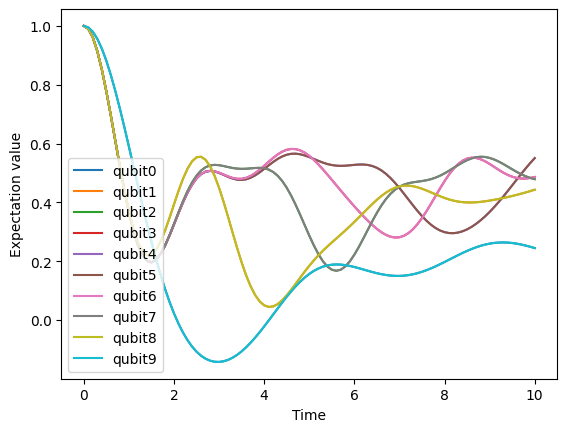

In [87]:
for i in range(num_sites):
    plt.plot(tlist, results_qutip.expect[i], label=f"qubit{i}")
plt.xlabel("Time")
plt.ylabel("Expectation value")
plt.legend()
plt.show()

#### PyTreeNet

In [88]:
from pytreenet.operators.models.two_site_model import IsingModel
from pytreenet.operators.models.topology import Topology
from pytreenet.time_evolution.bug import BUG, BUGConfig
from pytreenet.time_evolution.tdvp_algorithms.secondordertwosite import SecondOrderTwoSiteTDVP, TwoSiteTDVPConfig
from pytreenet.time_evolution.time_evolution import TimeEvoMode
from pytreenet.special_ttn.special_states import (generate_zero_state,
                                                  TTNStructure,
                                                  STANDARD_NODE_PREFIX)
from pytreenet.operators.models.eval_ops import local_magnetisation
from pytreenet.ttno import TTNO

In [89]:
init_state = generate_zero_state(num_sites, TTNStructure.BINARY, phys_dim=2, bond_dim=2)
node_ids = [STANDARD_NODE_PREFIX + str(i) for i in range(num_sites)]
model = IsingModel(factor=factor, ext_magn=ext_magn)
ham = model.generate_by_topology(Topology.CHAIN, num_sites, site_id_prefix=STANDARD_NODE_PREFIX)
ham_ttno = TTNO.from_hamiltonian(ham, init_state)
config = BUGConfig(time_evo_mode=TimeEvoMode.RK45, record_bond_dim=True)
eval_ops = local_magnetisation(node_ids)
bug = BUG(init_state, ham_ttno, 0.1, 10, eval_ops, config=config,
          solver_options={"rtol": 1e-8, "atol": 1e-8})
bug.run()
results_bug = bug.results

100%|██████████| 101/101 [00:08<00:00, 12.55it/s]


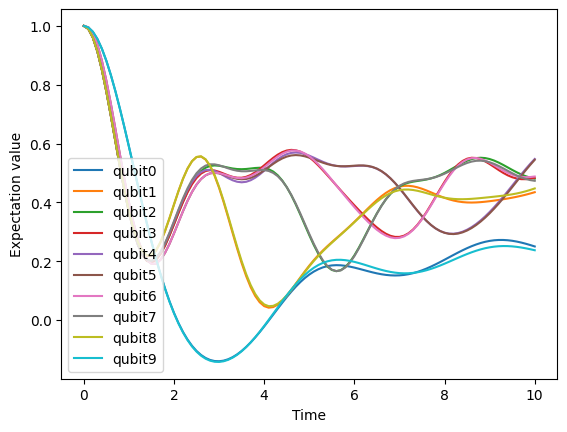

In [90]:
times = results_bug.times()
for node_id in node_ids:
    resu = results_bug.operator_result(node_id,realise=True)
    plt.plot(times, resu, label=f"{node_id}")
plt.xlabel("Time")
plt.ylabel("Expectation value")
plt.legend()
plt.show()

#### Comparison

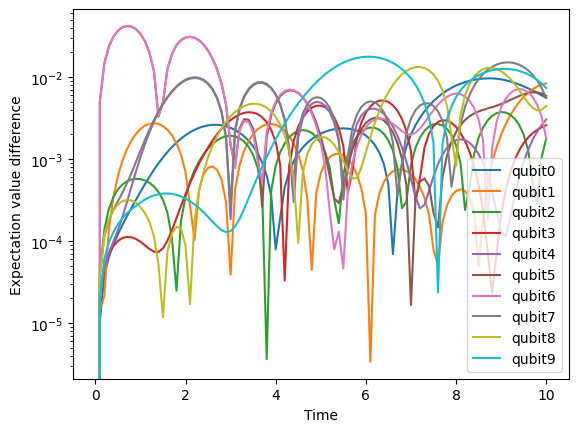

In [91]:
times = results.times()
for node_id in node_ids:
    res_bug = results_bug.operator_result(node_id,realise=True)
    res_qutip = results_qutip.expect[int(node_id[-1])]
    plt.semilogy(times, np.abs(res_bug - res_qutip), label=f"{node_id}")
plt.xlabel("Time")
plt.ylabel("Expectation value difference")
plt.legend()
plt.show()

/tmp/ipykernel_2226197/2394269267.py:3: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(results_bug.times(), value, label=key)


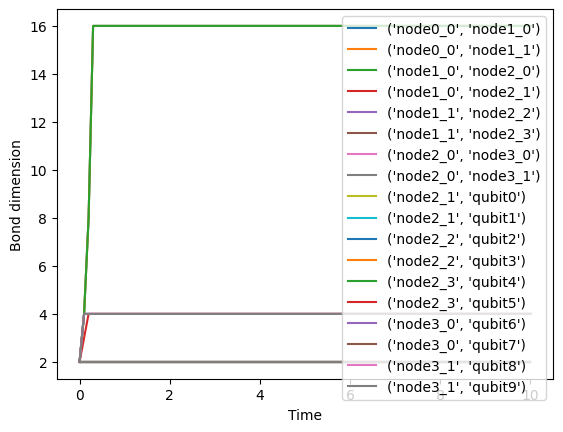

In [92]:
for key, value in results_bug.results.items():
    if isinstance(key, tuple):
        plt.plot(results_bug.times(), value, label=key)
plt.xlabel("Time")
plt.ylabel("Bond dimension")
plt.legend()
plt.show()